# Project 3 INF264

Author: Johanna Jøsang (fak006)

In [99]:
# Imports
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load data
label_data = np.genfromtxt('handwritten_digits_labels.csv', delimiter=',')
image_data = np.genfromtxt('handwritten_digits_images.csv', delimiter=',')
image_data = image_data.reshape(image_data.shape[0], 28, 28) # reshaping data

## Visualisation and preprocessing

In order to get a better understanding of the data I have been given, I start by gathering information about it.
First I would like to get a look at the shape of the data.

In [14]:
print("Label data shape:", label_data.shape)
print("Image data shape:", image_data.shape)

Label data shape: (70000,)
Image data shape: (70000, 28, 28)


As expected, the label dataset is a simple array with 70000 values, while the image dataset has 70000 2d arrays represetning the digit image.

Just to visalize the data for myself I print out a random image and its corresponding label.

At index 29527 there is a 4.0


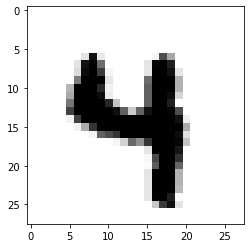

In [22]:
data_index = random.randint(0, label_data.size)
img = image_data[data_index]
plt.imshow(img, cmap="Greys")
print("At index", data_index, "there is a", label_data[data_index])

### Digit distribution

In order to find out how the data is distributed between the 10 digits, I print out the frequency, percentages and a histogram to see the distribution.

In [63]:
# Count number of examples for each digit
label_counter = collections.Counter(label_data)
print(label_counter)

# Print out the percentages for each digit
label_data_size = label_data.size
for i in range(10):
    percentage = (label_counter[i] / label_data_size) * 100
    print(i, ": ", "%.2f" % percentage, "%")
    
# Print min and max, which can easily be count ince label_counter is sorted by frequency
print("Min freq is 5 with", "%.2f" % ((label_counter[5] / label_data_size) * 100), "%")
print("Max freq is 1 with", "%.2f" % ((label_counter[1] / label_data_size) * 100), "%")

Counter({1.0: 7877, 7.0: 7293, 3.0: 7141, 2.0: 6990, 9.0: 6958, 0.0: 6903, 6.0: 6876, 8.0: 6825, 4.0: 6824, 5.0: 6313})
0 :  9.86 %
1 :  11.25 %
2 :  9.99 %
3 :  10.20 %
4 :  9.75 %
5 :  9.02 %
6 :  9.82 %
7 :  10.42 %
8 :  9.75 %
9 :  9.94 %
Min freq is 5 with 9.02 %
Max freq is 1 with 11.25 %


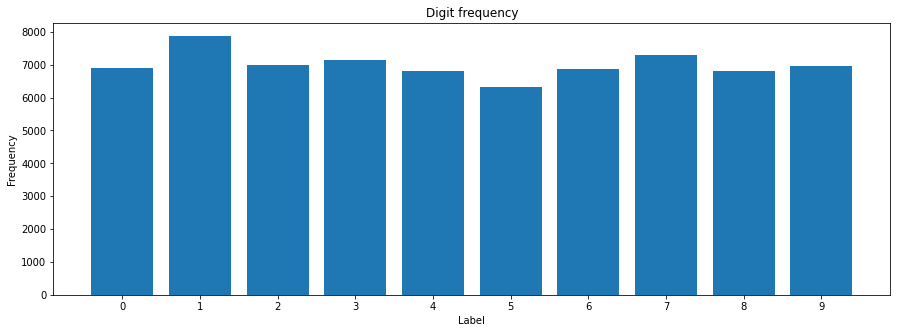

In [59]:
# Histogram
names = list(label_counter.keys())
values = list(label_counter.values())
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
plt.xticks(np.arange(0, 10))
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.title("Digit frequency");

All digits have about 10% of the data, so it does not seem like the dataset needs to be balanced. The least frequent digit was 5 (9.02 %) and the most frequent was 1 (11.25 %). If our trained classifiers become much worse at categorizing 5s compared to 1s then we can perhaps go back and balance the data.

In [157]:
X_train_val, X_test, y_train_val, y_test = train_test_split(image_data, label_data, test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, shuffle=True)


In [160]:
def reshape_3d_to_2d(data_3d):
    number_of_samples, x_dim, y_dim = data_3d.shape
    dataset_2d = data_3d.reshape((number_of_samples,x_dim*y_dim))
    return dataset_2d

X_train_2d = reshape_3d_to_2d(X_train)
X_val_2d = reshape_3d_to_2d(X_val)
X_train_val_2d = reshape_3d_to_2d(X_train_val)

In [83]:
clf = RandomForestClassifier()
clf.fit(X_train_2d, y_train)

#print(clf.predict([[0, 0, 0, 0]]))

RandomForestClassifier()

In [159]:
X_val_2d = reshape_3d_to_2d(X_val)
print(clf.score(X_val_2d, y_val))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [97]:
def kFold_cross_validation(X_train_val, y_train_val):
    kf = KFold(n_splits=5)
    score_count = []
    iteration_counter = 1
    for train_index, test_index in kf.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]
        clf.fit(X_train, y_train)
        iteration_score = clf.score(X_val, y_val)
        print("Iteration", iteration_counter, "score:", iteration_score)
        score_count.append(iteration_score)
    mean_score = np.mean(score_count)
    print("Mean score:", mean_score)
    return mean_score

In [98]:
X_train_val_2d = reshape_3d_to_2d(X_train_val)

mean_1 = kFold_cross_validation(X_train_val_2d, y_train_val)

Iteration 1 score: 0.9652380952380952
Iteration 1 score: 0.969920634920635
Iteration 1 score: 0.968015873015873
Iteration 1 score: 0.9691269841269842
Iteration 1 score: 0.9673809523809523
Mean score: 0.9679365079365081


In [100]:
print(cross_val_score(clf, X_train_val_2d, y_train_val))

[0.965      0.96865079 0.9681746  0.96801587 0.96785714]


In [101]:
print(np.mean([0.965, 0.96865079, 0.9681746, 0.96801587, 0.96785714]))

0.96753968


In [104]:
print(clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [106]:
acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
for i in range(1,30):
    clf = RandomForestClassifier(max_depth = i)
    cross_val_scores = cross_val_score(clf, X_train_val_2d, y_train_val)
    mean_cross_val_score = np.mean(cross_val_scores)
    print("Precision at depth", i , "is", mean_cross_val_score)
    acc_at_depth[i] = mean_cross_val_score 

Precision at depth 1 is 0.5350793650793652
Precision at depth 2 is 0.6343015873015874
Precision at depth 3 is 0.7414603174603175
Precision at depth 4 is 0.8155873015873016
Precision at depth 5 is 0.8588412698412698
Precision at depth 6 is 0.8875555555555555
Precision at depth 7 is 0.9095714285714285
Precision at depth 8 is 0.9230476190476191
Precision at depth 9 is 0.9362698412698414
Precision at depth 10 is 0.9445555555555554
Precision at depth 11 is 0.952
Precision at depth 12 is 0.9568730158730159
Precision at depth 13 is 0.9600634920634921
Precision at depth 14 is 0.9623809523809523
Precision at depth 15 is 0.964111111111111
Precision at depth 16 is 0.9652539682539683
Precision at depth 17 is 0.9670317460317459
Precision at depth 18 is 0.9662380952380951
Precision at depth 19 is 0.9670317460317459
Precision at depth 20 is 0.967047619047619
Precision at depth 21 is 0.9667460317460318
Precision at depth 22 is 0.9676190476190477
Precision at depth 23 is 0.966968253968254
Precision at 

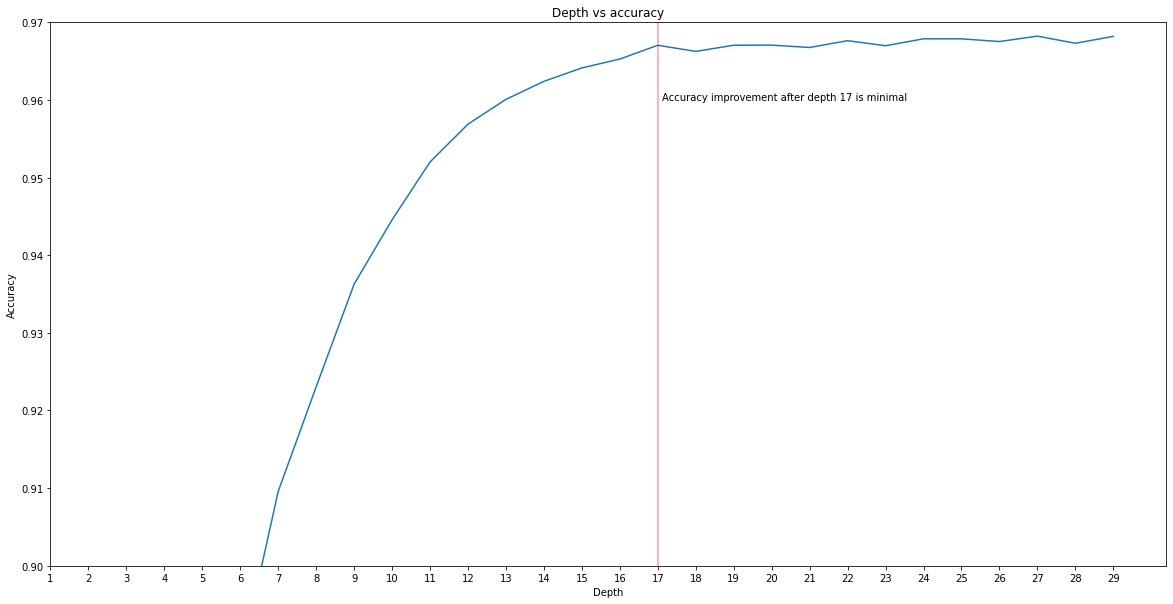

In [139]:
x = acc_at_depth.keys()
y = acc_at_depth.values()
fig = plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.axvline(x=17, ymin=0, ymax=1, color = 'r', alpha = 0.4)
plt.text(17.1, 0.96, "Accuracy improvement after depth 17 is minimal")
plt.xlim(left=13)
plt.ylim(bottom=0.9, top = 0.97)
plt.title("Depth vs accuracy")
plt.xticks(np.arange(1, 30, 1))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

The graph above only examines the range between acciracies 0.9-0.97. We can now see that after depth 17, the accuracy of the classifier does not really improve by much. Hence, we chose depth = 17 for our random forest classifier.

### Impurity measure
We will use k-fold cross valudation to check if gini or entropy is best as impurity measure.

In [143]:
clf = RandomForestClassifier(criterion = 'gini', max_depth = 17)
cross_val_score_gini = np.mean(cross_val_score(clf, X_train_val_2d, y_train_val))
print(cross_val_score_gini)
clf = RandomForestClassifier(criterion = 'entropy', max_depth = 17)
cross_val_score_entropy = np.mean(cross_val_score(clf, X_train_val_2d, y_train_val))
print(cross_val_score_entropy)

0.966079365079365
0.9665873015873017


In [148]:
diff_percentage = (np.abs(cross_val_score_gini-cross_val_score_entropy)/ ((cross_val_score_entropy+cross_val_score_gini)/2)) *100
print("Accuracy difference between gini and entropy:", "%.2f" % diff_percentage, "%")

Accuracy difference between gini and entropy: 0.05 %


While entropy has slightly higher accuracy than gini, the difference is only 0.05%. Since gini requires less computation than entropy, it will be chosen as impurity measure.


### Number of trees
Now we will take a look at the optimal number of trees required. First we will iterate over 10 segments of 50, to get a rough idea of where the optimal number of trees lies.

In [163]:
acc_ntrees = {} # Dictionary for keeping track of number of trees and accuracy
for i in range(50, 400, 50):
    clf = RandomForestClassifier(n_estimators = i, criterion = 'gini', max_depth = 17)
    clf.fit(X_train_2d, y_train)
    score = clf.score(X_val_2d, y_val)
    print("Precision at tree number", i , "is:", score)
    acc_ntrees[i] = score 

Precision at tree number 50 is: 0.9638095238095238
Precision at tree number 100 is: 0.9653968253968254
Precision at tree number 150 is: 0.9685714285714285
Precision at tree number 200 is: 0.9692063492063492
Precision at tree number 250 is: 0.9680952380952381
Precision at tree number 300 is: 0.9687301587301588
Precision at tree number 350 is: 0.9687301587301588


dict_keys([])
dict_values([])


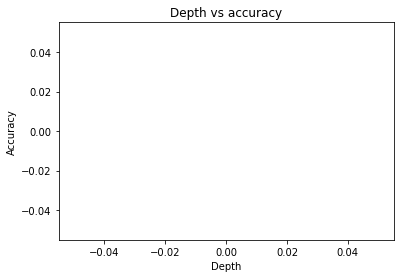

In [167]:
x = acc_ntrees.keys()
y = acc_ntrees.values()
print(x)
print(y)
#fig = plt.figure(figsize=(20,10))
plt.plot(x,y)
#plt.axvline(x=17, ymin=0, ymax=1, color = 'r', alpha = 0.4)
#plt.text(17.1, 0.96, "Accuracy improvement after depth 17 is minimal")
#plt.xlim(left=13)
#plt.ylim(bottom=0.9, top = 0.97)
plt.title("Depth vs accuracy")
#plt.xticks(np.arange(1, 30, 1))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

In [173]:
diff_percentage = np.abs(0.9653968253968254-0.9685714285714285)
print("Accuracy difference between 100 and 150 trees:", "%.3f" % diff_percentage)
diff_percentage = np.abs(0.9653968253968254-0.9638095238095238)
print("Accuracy difference between 100 and 150 trees:", "%.3f" % diff_percentage)

Accuracy difference between 100 and 150 trees: 0.003
Accuracy difference between 100 and 150 trees: 0.002
